# Data Attribute Recommendation - Regression Model Template

Deep dive into the newest feature of the Data Attribute Recommendation service: the Regression model template.

## Business Scenario

We will consider a business scenario involving real estate valuation. Based on historical real estate data, we will learn how to predict the price for real estate.

This workshop will cover:
    
* Data Upload
* Model Training and Deployment
* Inference Requests
    
We will work through a basic example of how to achieve these tasks using the [Python SDK for Data Attribute Recommendation](https://github.com/SAP/data-attribute-recommendation-python-sdk).

## How to use this notebook

A Jupyter notebook combines code and documentation. To run the exercises in this workshop, simply follow the instructions in the documentation cells.

Additional information is available through the notebook in hidden boxes marked with the ✐ icon. It is not required to read through these sections, but it is occasionally helpful.

<details>
    <summary><em> ✐ Click this to reveal additional information</em></summary>
    <br/>

Thank you!
</details>

<br/>

To execute the code cells, click the "Play" ▶️ button at the top of your screen. The code cells must be executed in the order that they appear in this notebook.




<details>
    <summary><em> ✐ Doing several runs of the notebook and you get errors?</em></summary>
    <br/>

If you are doing several runs of this notebook on a trial account, you may see errors stating 'The resource can no longer be used. Usage limit has been reached'. It can be beneficial to [clean up the service instance](#Cleaning-up-a-service-instance) to free up limited trial resources acquired by an earlier run of the notebook. [Some limits](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/c03b561eea1744c9b9892b416037b99a.html) cannot be reset this way.
</details>

## Table of Contents

* [Exercise 01.1](#Exercise-01.1) - Installing the SDK and preparing the service key
    * [Creating a service instance and key on BTP Trial](#Creating-a-service-instance-and-key-on-BTP-Trial)
    * [Loading the service key into your Jupyter Notebook](#Loading-the-service-key-into-your-Jupyter-Notebook)
    * [Installing the SDK](#Installing-the-SDK)
* [Exercise 01.2](#Exercise-01.2) - Uploading the data
* [Exercise 01.3](#Exercise-01.3) - Training the model
* [Exercise 01.4](#Exercise-01.4) - Deploying the Model and predicting labels
* [Resources](#Resources) - Additional reading
* [Addendum](#Addendum)
    * [Inference without the SDK](#Inference-without-the-SDK) - Call the API without Python or the SDK
    * [Cleaning up a service instance](#Cleaning-up-a-service-instance) - Clean up all resources on the service instance
    * [Optional Exercises](#Optional-Exercises) - Optional exercises

# Exercise 01.1

*Back to [table of contents](#Table-of-Contents)*

In exercise 01.1, we will install the SDK and prepare the service key.

## Creating a service instance and key on BTP Trial

Please log in to your trial account: https://cockpit.eu10.hana.ondemand.com/trial/

In the your global account screen, go to the "Boosters" tab:

![trial_booster.png](./images/trial_booster.png)

*Boosters are only available on the Trial landscape. If you are using a production environment, please follow this tutorial to manually [create a service instance and a service key](https://developers.sap.com/tutorials/cp-aibus-dar-service-instance.html)*.
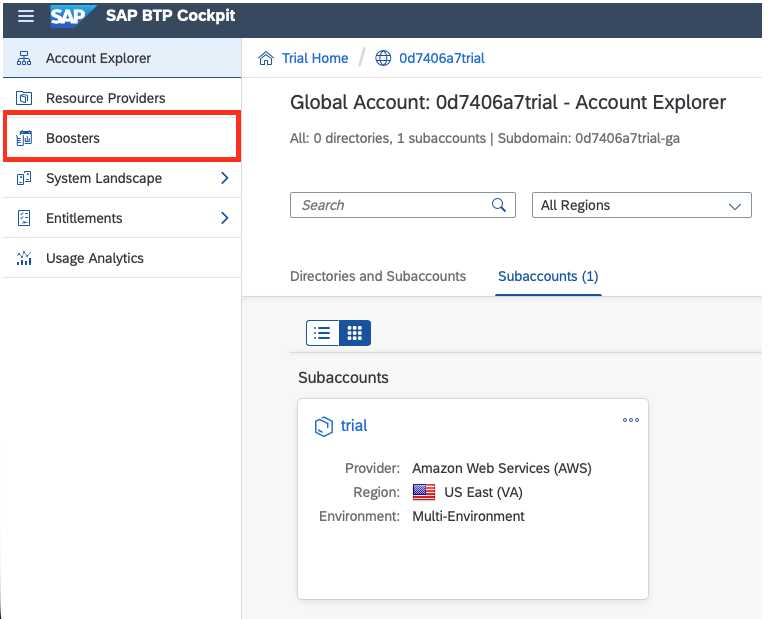

In the Boosters tab, enter "Data Attribute Recommendation" into the search box. Then, select the
service tile from the search results: 
    
![trial_locate_dar_booster.png](./images/trial_locate_dar_booster.png)
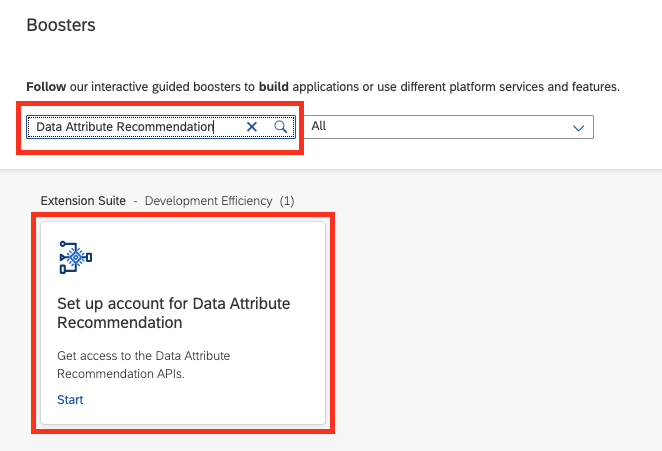

The resulting screen shows details of the booster pack. Here, click the "Start" button and wait a few seconds.

![trial_start_booster.png](./images/trial_start_booster.png)
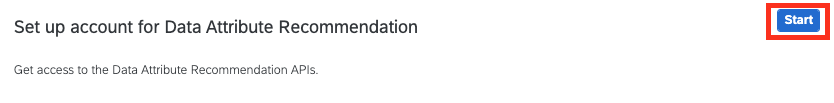

Once the booster is finished, click the "Download Service Key" button to obtain your service key.

![trial_booster_finished.png](./images/trial_booster_finished.png)
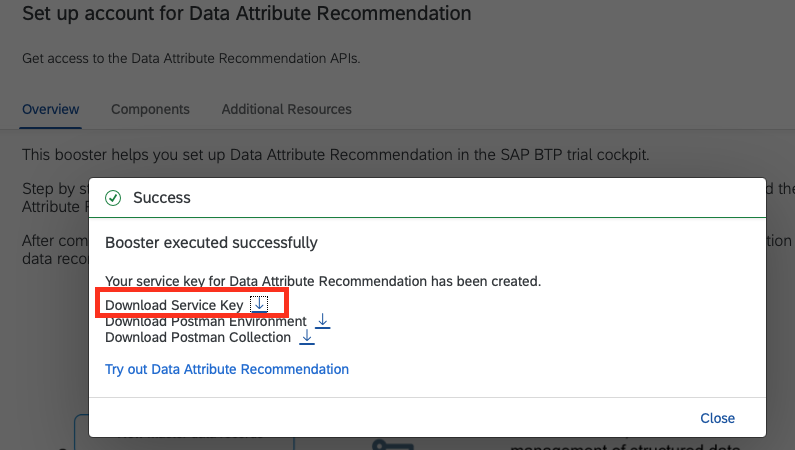

## Loading the service key into your Jupyter Notebook

Once you downloaded the service key from the Cockpit, upload it to your notebook environment. The service key must be uploaded to same directory where the `Data_Attribute_Recommendation_*_Model_Template.ipynb` file is stored.

When using Jupyterlab, a file browser is visible to the left of the notebook view. Click the upload button here to upload the `default_key.json` file we downloaded earlier from the BTP Cockpit.


![jupyterlab_upload_button.png](./images/service_key_main_jupyter_page.png)
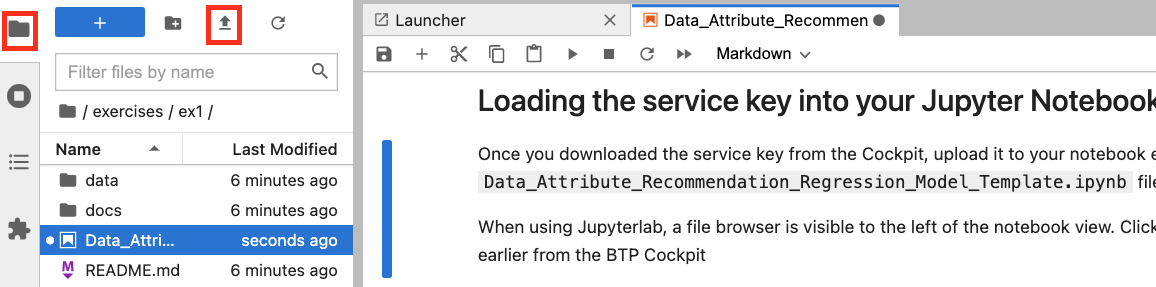

Once you click the upload button, a file chooser dialog will open where you can select the `default_key.json`:
After the upload finished successfully, you should see the `default_key.json` in the file browser.

![jupyterlab_service_key_uploaded_successfully.png](./images/service_key_upload.png)

**Make sure that the file name is `default_key.json`. If your service key file has a different name, this notebook will not work.**
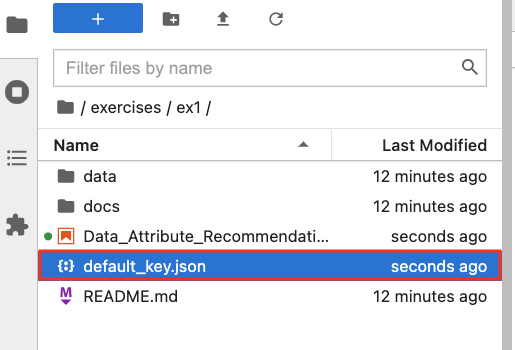

The service key contains your credentials to access the service. Please treat this as carefully as you would treat any password. We keep the service key as a separate file outside this notebook to avoid leaking the secret credentials.

The service key is a JSON file. We will load this file once and use the credentials throughout this workshop. 

In [ ]:
# First, set up logging so we can see the actions performed by the SDK behind the scenes
import logging
import sys

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

from pprint import pprint # for nicer output formatting

In [ ]:
import json
import os

if not os.path.exists("default_key.json"):
    msg = "'default_key.json' is not found. Please follow instructions above to create a service key of"
    msg += " Data Attribute Recommendation. Then, upload it into the same directory where"
    msg += " this notebook is saved."
    print(msg)
    raise ValueError(msg)

with open("default_key.json") as file_handle:
    key = file_handle.read()
    SERVICE_KEY = json.loads(key)
    print("Service URL: ")
    pprint(SERVICE_KEY["url"])
    print("Client ID:")
    pprint(SERVICE_KEY["uaa"]["clientid"])

## Installing the SDK

The Data Attribute Recommendation SDK is available from the Python package repository. It can be installed with the standard `pip` tool:

In [ ]:
! pip install data-attribute-recommendation-sdk

<details>
    <summary><em> ✐ If you are not using a Jupyter notebook</em></summary>
    <br/>
If you are not using a Jupyter notebook, but instead a regular Python development environment, we recommend using a Python virtual environment to set up your development environment. Please see [the dedicated tutorial to learn how to install the SDK inside a Python virtual environment](https://developers.sap.com/tutorials/cp-aibus-dar-sdk-setup.html).

    </details>

## Summary Exercise 01.1

In exercise 01.1, we have covered the following topics:

* How to obtain a service key for the Data Attribute Recommendation service
* How to install the Python SDK for Data Attribute Recommendation

# Exercise 01.2

*Back to [table of contents](#Table-of-Contents)*
*To perform this exercise, you need to execute the code in all previous exercises.*

In exercise 01.2, we will upload our demo dataset to the service.

## The Dataset

### Obtaining the Data

The dataset we use in this workshop is a CSV file containing real estate valuation data. The original data was released by Prof. I-Cheng Yeh from  Tamkang University in Taiwan under the [CC BY 4.0 license]. The original dataset is available from the [UCI Machine Learning Repository] ([license reference]).

[CC BY 4.0 license]: https://creativecommons.org/licenses/by/4.0/
[UCI Machine Learning Repository]: https://archive.ics.uci.edu/ml/datasets/real+estate+valuation+data+set
[license reference]: https://archive-beta.ics.uci.edu/ml/datasets/real+estate+valuation+data+set

The open license makes it ideal for first experiments with the Data Attribute Recommendation service. For the purpose of this workshop, we lightly modified the dataset. The dataset used here is thus a derivative work of the original.

The dataset is available in the Github repository for this workshop in the `data` directory.

Let's inspect the data:

In [ ]:
# if you are experiencing an import error here, run the following in a new cell:
# ! pip install pandas
import pandas as pd

df = pd.read_csv("data/real_estate_valuation_data_set.csv")
df.head(5)

In [ ]:
print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns.")

The CSV contains historical price data for real estate sales from 2012 and 2013 in the Sindian District, New Taipei City, Taiwan.

The following columns are present in the data:

| Column | Meaning |
| :--- | :--- |
| transaction\_date | Year and Month in fractional notation. 2013.500 = June 2013 |
| house\_age | Age of house in years |
| distance\_to\_nearest\_MRT\_station | Distance to public transport station |
| number\_of\_convenience\_stores | Amount of stores are nearby |
| latitude | Geographical coordinate |
| longitude | Geographical coordinate |
| **house\_price\_per\_m2** | House price in New Taiwan Dollars per square meter |


In this workshop, we will predict the **`house_price_per_m2`** based on the `transaction_date`, `house_age`, `distance_to_nearest_MRT_station`, `number_of_convenience_stores`, `latitude` and `longitude`.

### Creating the DatasetSchema

We first have to describe the shape of our data by creating a DatasetSchema. This schema informs the service about the individual column types found in the CSV. We also describe which are the target columns used for training. These columns will be later predicted. In our case, this is the `house_price_per_m2` column.

The service currently supports three column types: **TEXT**, **CATEGORY** and **NUMBER**. As labels to be predicted, only **CATEGORY** and **NUMBER** is currently supported.

A DatasetSchema for the dataset looks as follows:

```json
dataset_schema = {
    "features": [
        {"label": "transaction_date", "type": "NUMBER"},
        {"label": "house_age", "type": "NUMBER"},
        {"label": "distance_to_nearest_MRT_station", "type": "NUMBER"},
        {"label": "number_of_convenience_stores", "type": "NUMBER"},
        {"label": "latitude", "type": "NUMBER"},
        {"label": "longitude", "type": "NUMBER"},
    ],
    "labels": [
        {"label": "house_price_per_m2", "type": "NUMBER"}
    ],
    "name": "real-estate-price-prediction",
}
```

*Note: In this example, we use only NUMBER as feature type.*


We will now upload this DatasetSchema to the Data Attribute Recommendation service. The SDK provides the
[`DataManagerClient.create_dataset_schema()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.create_dataset_schema) method for this purpose.


In [ ]:
from sap.aibus.dar.client.data_manager_client import DataManagerClient

dataset_schema = {
    "features": [
        {"label": "transaction_date", "type": "NUMBER"},
        {"label": "house_age", "type": "NUMBER"},
        {"label": "distance_to_nearest_MRT_station", "type": "NUMBER"},
        {"label": "number_of_convenience_stores", "type": "NUMBER"},
        {"label": "latitude", "type": "NUMBER"},
        {"label": "longitude", "type": "NUMBER"},
    ],
    "labels": [
        {"label": "house_price_per_m2", "type": "NUMBER"}
    ],
    "name": "real-estate-price-prediction",
}


data_manager = DataManagerClient.construct_from_service_key(SERVICE_KEY)
response = data_manager.create_dataset_schema(dataset_schema)
dataset_schema_id = response["id"]

print()
print("DatasetSchema created:")

pprint(response)

print()
print(f"DatasetSchema ID: {dataset_schema_id}")

The API responds with the newly created DatasetSchema resource. The service assigned an ID to the schema. We save this ID in the `dataset_schema_id` variable, as we will need it when we upload the data.

### Uploading the Data to the service

The [`DataManagerClient`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient) class is also responsible for uploading data to the service. This data must fit to an existing DatasetSchema. After uploading the data, the service will validate the Dataset against the DatasetSchema in a background process. The data must be a CSV file which can optionally be `gzip` compressed.

We will now upload our `real_estate_valuation_data_set.csv` file, using the DatasetSchema which we created earlier.

Data upload is a two-step process. We first create the Dataset using [`DataManagerClient.create_dataset()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.create_dataset).

In [ ]:
dataset_resource = data_manager.create_dataset("real-estate-price-prediction", dataset_schema_id)
dataset_id = dataset_resource["id"]

print()
print("Dataset created:")

pprint(dataset_resource)

print()
print(f"Dataset ID: {dataset_id}")

We can now upload data to the Dataset using the [`DataManagerClient.upload_data_to_dataset()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.upload_data_to_dataset) method.

In [ ]:
# Compress file first for a faster upload
! gzip -9 -c data/real_estate_valuation_data_set.csv > data/real_estate_valuation_data_set.csv.gz

Note that the data upload can take a few minutes. Please do not restart the process while the cell is still running.

In [ ]:
# Open in binary mode.
with open('data/real_estate_valuation_data_set.csv.gz', 'rb') as file_handle:
    dataset_resource = data_manager.upload_data_to_dataset(dataset_id, file_handle)

print()
print("Dataset after data upload:")
print()
pprint(dataset_resource)

Note that the Dataset status changed from `NO_DATA` to `VALIDATING`.

Dataset validation is a background process. The status will eventually change from `VALIDATING` to `SUCCEEDED`.
The SDK provides the [`DataManagerClient.wait_for_dataset_validation()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.wait_for_dataset_validation) method to poll for the Dataset validation.

In [ ]:
dataset_resource = data_manager.wait_for_dataset_validation(dataset_id)

print()
print("Dataset after validation has finished:")

print()
pprint(dataset_resource)

If the status is `FAILED` instead of `SUCCEEDED`, then the `validationMessage` will contain details about the validation failure.

To better understand the Dataset lifecycle, refer to the [corresponding document on help.sap.com](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/a9b7429687a04e769dbc7955c6c44265.html).

#### Break Time

The data validation will take between 1 and 10 minutes.

In the meantime, we can explore the available [resources](#Resources) for both the service and the SDK.

## Summary Exercise 01.2

In exercise 01.2, we have covered the following topics:

* How to create a DatasetSchema
  * The DatasetSchema describes your unique Dataset to the service
* How to upload a Dataset to the service

You can find optional exercises related to exercise 01.2 [below](#Optional-Exercises-for-01.2).

# Exercise 01.3

*Back to [table of contents](#Table-of-Contents)*

*To perform this exercise, you need to execute the code in all previous exercises.*

In exercise 01.3, we will train the model.

## Training the Model

The Dataset is now uploaded and has been validated successfully by the service.

To train a machine learning model, we first need to select the correct ModelTemplate. A ModelTemplate is a machine learning algorithm inside the Data Attribute Recommendation service.

### Selecting the right ModelTemplate

The Data Attribute Recommendation service currently supports the following ModelTemplates:

| ID                                   | Name                  | Description                                                               |
|--------------------------------------|---------------------------|---------------------------------------------------------------------------|
| d7810207-ca31-4d4d-9b5a-841a644fd81f | **Hierarchical template** | Recommended for the prediction of multiple classes that form a hierarchy. |
| 223abe0f-3b52-446f-9273-f3ca39619d2c | **Generic template**      | Generic neural network for multi-label, multi-class classification.       |
| 188df8b2-795a-48c1-8297-37f37b25ea00 | **AutoML template**      | Finds the best machine learning model out of several traditional algorithms. Single output only. ([Blog post](https://blogs.sap.com/2021/04/28/how-does-automl-works-in-data-attribute-recommendation/)) |
| bdbcd699-4419-40a5-abb8-e7ad43dde49b | **Regression template**      | Predict the numeric value of a field. Single output only. ([Blog post](https://blogs.sap.com/2021/11/14/solving-regression-use-cases-with-data-attribute-recommendation/)) |


We are building a model to predict the price of a house per square metre. The **Regression Template** is correct for this scenario. 

Refer to the [official documentation on ModelTemplates](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/1e76e8c636974a06967552c05d40e066.html) to learn more. Additional model templates may be added over time, so check back regularly.

### Starting the training

When working with models, we use the [`ModelManagerClient`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient) class.

To start the training, we need the IDs of the dataset and the desired model template. We also have to provide a name for the model.
The [`ModelManagerClient.create_job()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.create_job) method launches the training Job.

<details>
<summary><em> ✐ Handling 'The model name specified is already in use' errors.</em></summary>
<br/>

Only one model of a given name can exist. If you receive a message stating 'The model name specified is already in use', you either have to remove the job and its associated model first or you have to change the `model_name` variable name below. You can also [clean up the entire service instance](#Cleaning-up-a-service-instance).
</details>

In [ ]:
from sap.aibus.dar.client.model_manager_client import ModelManagerClient
from sap.aibus.dar.client.exceptions import DARHTTPException

model_manager = ModelManagerClient.construct_from_service_key(SERVICE_KEY)

In [ ]:
model_template_id = "bdbcd699-4419-40a5-abb8-e7ad43dde49b" # regression template
model_name = "real-estate-valuation"

job_resource = model_manager.create_job(model_name, dataset_id, model_template_id)
job_id = job_resource['id']

print()
print("Job resource:")
print()

pprint(job_resource)

print()
print(f"ID of submitted Job: {job_id}")

The job is now running in the background. Similar to the Dataset validation, we have to poll the job until it succeeds.
The SDK provides the [`ModelManagerClient.wait_for_job()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.wait_for_job) method:

In [ ]:
job_resource = model_manager.wait_for_job(job_id)

print()

print("Job resource after training is finished:")

pprint(job_resource)

To better understand the Training Job lifecycle, see the [corresponding document on help.sap.com](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/0fc40aa077ce4c708c1e5bfc875aa3be.html).

#### Break Time

The model training will take between 1 and 10 minutes.

In the meantime, we can explore the available [resources](#Resources) for both the service and the SDK.

## Inspecting the Model

Once the training job is finished successfully, we can inspect the model using [`ModelManagerClient.read_model_by_name()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_model_by_name).


In [ ]:
model_resource = model_manager.read_model_by_name(model_name)

print()
pprint(model_resource)

In the model resource, the `validationResult` key provides information about model performance. You can also use these metrics to compare performance of different [ModelTemplates](#Selecting-the-right-ModelTemplate) or different datasets.

For regression model templates, you will see the following metrics:

* **`meanAbsoluteError`** - **Mean Absolute Error (MAE)**: Average absolute difference between the predicted values and the actual values.
* **`meanAbsolutePercentageError`** - **Mean Absolute Percentage Error (MAPE)**: Average of the absolute percentage errors of the predictions. May exceed 100% for predictions which are too high.
* **`meanSquaredError`** - **Mean Squared Error (MSE)**: Average squared difference between the predicted values and the actual values.

The Mean Squared Error (MSE) is the metric optimized during training.

To interpret the absolute **MAE**, you need to consider the range of your data. If the data you are predicting has a range from `1` to `5`, then a **MAE** value of `3` would not be very good. If the data has a range between `100` and `1000`, then a **MAE** of `3` would be quite good.

The **MAPE** is a relative value. A **MAPE** of 30 means that on average, the predictions were off by `30%` on the test set.

## Summary Exercise 01.3

In exercise 01.3, we have covered the following topics:

* How to select the appropriate ModelTemplate
* How to train a Model from a previously uploaded Dataset
* How to understand Model performance from the Model metrics

You can find optional exercises related to exercise 01.3 [below](#Optional-Exercises-for-01.3).

# Exercise 01.4

*Back to [table of contents](#Table-of-Contents)*

*To perform this exercise, you need to execute the code in all previous exercises.*

In exercise 01.4, we will deploy the model and generate predictions for some unlabeled data.

## Deploying the Model

The training job has finished and the model is ready to be deployed. By deploying the model, we create a server process in the background on the Data Attribute Recommendation service which will serve inference requests.

In the SDK, the [`ModelManagerClient.create_deployment()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#module-sap.aibus.dar.client.model_manager_client) method lets us create a Deployment.

In [ ]:
deployment_resource =  model_manager.create_deployment(model_name)
deployment_id = deployment_resource["id"]

print()
print("Deployment resource:")
print()

pprint(deployment_resource)


print(f"Deployment ID: {deployment_id}")

<details>
<summary><em> ✐ Handling 'The resource can no longer be used. Usage limit has been reached'.</em></summary>

<br/>
    
If you are using a trial account and you see errors such as 'The resource can no longer be used. Usage limit has been reached', consider [cleaning up the service instance](#Cleaning-up-a-service-instance) to free up limited trial resources.

Alternatively, instead of cleaning up the entire service instance, you can check if we have any running deployments using [`ModelManagerClient.read_deployment_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_deployment_collection). On trial instances, only one concurrent deployment is allowed. If you have one deployment here, see [`ModelManagerClient.delete_deployment_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.delete_deployment_by_id)
</details>

Similar to the data upload and the training job, model deployment is an asynchronous process. We have to poll the API until the Deployment is in status `SUCCEEDED`. The SDK provides the [`ModelManagerClient.wait_for_deployment()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.wait_for_deployment) for this purposes.

In [ ]:
deployment_resource = model_manager.wait_for_deployment(deployment_id)

print()
print("Finished deployment resource:")
print()

pprint(deployment_resource)

Once the Deployment is in status `SUCCEEDED`, we can run inference requests. To learn more, see the article on [Deployment Lifecycle](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/f473b5b19a3b469e94c40eb27623b4f0.html) in the SAP Help Portal.

<details>
    
<summary>✐ <em>For trial users: the deployment will be stopped after 8 hours.</em></summary>

<br/>
    
You can restart it by deleting the deployment and creating a new one for your model. The [`ModelManagerClient.ensure_deployment_exists()`](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/c03b561eea1744c9b9892b416037b99a.html) method will delete and re-create automatically. Then, you need to poll until the deployment is succeeded using [`ModelManagerClient.wait_for_deployment()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.wait_for_deployment) as above.*
    
</details>

### Break Time

The model deployment training will take between 1 and 5 minutes.

In the meantime, we can explore the available [resources](#Resources) for both the service and the SDK.

## Executing Inference requests

With a single inference request, we can send up to 50 objects to the service to predict the labels. The data send to the service must match the `features` section of the DatasetSchema created earlier. The `labels` defined inside of the DatasetSchema will be predicted for each object and returned as a response to the request.

In the SDK, the [`InferenceClient.create_inference_request()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.inference_client.InferenceClient.create_inference_request) method handles submission of inference requests.

In [ ]:
from sap.aibus.dar.client.inference_client import InferenceClient

inference = InferenceClient.construct_from_service_key(SERVICE_KEY)

objects_to_be_classified = [
    {
        "features": [
            {"name": "transaction_date", "value": "2013.167"},
            {"name": "house_age", "value": "1.1"},
            {"name": "distance_to_nearest_MRT_station", "value":  "193.584"},
            {"name": "number_of_convenience_stores", "value":  "6.0"},
            {"name": "latitude", "value":  "24.966"},
            {"name": "longitude", "value":  "121.541"},
        ],
    },
    {
        "features": [
            {"name": "transaction_date", "value": "2013.417"},
            {"name": "house_age", "value": "32.8"},
            {"name": "distance_to_nearest_MRT_station", "value":  "204.171"},
            {"name": "number_of_convenience_stores", "value":  "8.0"},
            {"name": "latitude", "value":  "24.982"},
            {"name": "longitude", "value":  "121.539"},
        ],
    },
]

inference_response = inference.create_inference_request(model_name, objects_to_be_classified)

print()
print("Inference request processed. Response:")
print()
pprint(inference_response)

*Note: For trial accounts, you only have a limited number of objects which you can classify.*

<!-- Results above: --> 
<!-- first object is from the training set. We expect a lower STD here because the model has seen the data. Real value is 159.06 -->
<!-- second object is from the test set. STD is higher here because the model has not seen the data. Real value is 170.01 -->

The predictions are returned as a list where each entry correspond to the object you sent for classification. Inside of the prediction object, you can find the result:

```json
  {
    "labels": [
      {
        "name": "house_price_per_m2",
        "results": [
          {
            "std": 16.9080085754,
            "value": "130.0392456055"
          }
        ]
      }
    ]
  }
```
```json
{
  "labels": [
    {
      "name": "house_price_per_m2",
      "results": [
        {
          "std": 30.4755897522,
          "value": "206.2890319824"
        }
      ]
    }
  ]
}

```

The results shown above may differ slightly from your own inference results.

The `value` gives the prediction while the `std` gives the standard deviation. The `std` value serves as an indicator of confidence: if the `std` value is relatively large compared to the `value`, then the model is not very confident for this particular prediction. We can compare the confidence between the two predictions above by computing the ratio between `value` and `std`.

```
16.9 / 130.0 = 0.13 = 13% # first prediction
30.5 / 206.3 = 0.15 = 15% # second prediction
```

For the first prediction, the `std` is `13%` of the `value`. For the second prediction, the `std` is `15%` of the `value`. The model is slightly more confident about the first prediction.

<details>
<summary> ✐ <em>Learn how <code>std</code> is computed</em> </summary>

<br/>

To compute the standard deviation, the Data Attribute Recommendation service needs multiple values. These values are obtained by repeatedly sampling the prediction of the machine learning model. In a typical machine learning model, the prediction would always be the same.
    
In the machine learning model used for the regression template in Data Attribute Recommendation, a [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) layer is active both during training and inference. A dropout layer randomly sets the previous layer's outputs to 0. The intuition here is that the neural network will be more robust by learning multiple subnets.

At inference time, the service leverages the same intuition by repeatedly sampling the model. The different subnets model will return their individual predictions. If the predictions are very similar, we know that different subnets agree and the model is very confident. If the predictions differ wildly, we know that the model is not very certain about its prediction.
    
The `value` is then the average of the internally sampled predictions while the `std` is the standard deviation of the internally sampled predictions.

The model is typically more confident about data points that are close to the training data. If you observe that confidence goes down over time in your machine learning implementation due to data drift, you may want to consider retraining based on more recent data.

Confidence (i.e. the ratio between `value` and `std`) will also differ based on the use case, distribution of training data and various other factors. It is best to compare the confidence between predictions created with the same model. To understand what constitutes good and bad confidence levels, you can execute several inference requests to understand the distribution of the confidence.

</details>

To learn how to execute inference calls without the SDK just using the underlying RESTful API, see [Inference without the SDK](#Inference-without-the-SDK).

You can also try to come up with your own example:

<!-- Example below is second object from test set -->

In [ ]:
my_own_items = [
    {
        "features": [
            {"name": "transaction_date", "value": "2013.083"},
            {"name": "house_age", "value": "16.1"},
            {"name": "distance_to_nearest_MRT_station", "value":  "289.325"},
            {"name": "number_of_convenience_stores", "value":  "5.0"},
            {"name": "latitude", "value":  "24.982"},
            {"name": "longitude", "value":  "121.543"},
        ],
    },
]


inference_response = inference.create_inference_request(model_name, my_own_items)

print()
print("Inference request processed. Response:")
print()
pprint(inference_response)

## Summary Exercise 01.4

In exercise 01.4, we have covered the following topics:

* How to deploy a previously trained model
* How to understand model confidence for individual predictions
* How to execute inference requests against a deployed model

You can find optional exercises related to exercise 01.4 [below](#Optional-Exercises-for-01.4).

# Wrapping up

In this workshop, we looked into the following topics:

* Installation of the Python SDK for Data Attribute Recommendation
* Modelling data with a DatasetSchema
* Uploading data into a Dataset
* Training a model
* Obtain predictions for unlabelled data

Using these tools, we are able to solve to predict the house price per m^2 starting from just a CSV file containing training data.

Feel free to revisit the workshop materials at any time. The [resources](#Resources) section below contains additional reading.

If you would like to explore the additional capabilities of the SDK, visit the [optional exercises](#Optional-Exercises) below.

## Cleanup

During the course of the workshop, we have created several resources on the Data Attribute Recommendation Service:

* DatasetSchema
* Dataset
* Job
* Model
* Deployment

The SDK provides several methods to delete these resources. Note that there are dependencies between objects: you cannot delete a Dataset without deleting the Model beforehand.

You will need to set `CLEANUP_SESSION = True` below to execute the cleanup.

In [ ]:
# Clean up all resources created earlier

CLEANUP_SESSION = False

def cleanup_session():
    model_manager.delete_deployment_by_id(deployment_id) # this can take a few seconds
    model_manager.delete_model_by_name(model_name)
    model_manager.delete_job_by_id(job_id)

    data_manager.delete_dataset_by_id(dataset_id)
    data_manager.delete_dataset_schema_by_id(dataset_schema_id)
    print("DONE cleaning up!")

if CLEANUP_SESSION:
    print("Cleaning up resources generated in this session.")
    cleanup_session()
else:
    print("Not cleaning up. Set 'CLEANUP_SESSION = True' above and run again!")

## Resources

*Back to [table of contents](#Table-of-Contents)*


### Data Attribute Recommendation

* [SAP Help Portal](https://help.sap.com/viewer/product/Data_Attribute_Recommendation/SHIP/en-US)
* [API Reference](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/b45cf9b24fd042d082c16191aa938c8d.html)
* [Tutorials using Postman - interact with the service RESTful API directly](https://developers.sap.com/mission.cp-aibus-data-attribute.html)
* [Trial Account Limits](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/c03b561eea1744c9b9892b416037b99a.html)
* [Metering and Pricing](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/1e093326a2764c298759fcb92c5b0500.html)
* [Blog Post: How does AutoML work in Data Attribute Recommendation?](https://blogs.sap.com/2021/04/28/how-does-automl-works-in-data-attribute-recommendation/)
* [Blog Post: Solving regression use-cases with Data Attribute Recommendation](https://blogs.sap.com/2021/11/14/solving-regression-use-cases-with-data-attribute-recommendation/)
* [All Blog Posts on Data Attribute Recommendation](https://blogs.sap.com/tags/73554900100800002858/)

### SDK Resources

* [SDK source code on Github](https://github.com/SAP/data-attribute-recommendation-python-sdk)
* [SDK documentation](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/)
* [How to obtain support](https://github.com/SAP/data-attribute-recommendation-python-sdk/blob/master/README.md#how-to-obtain-support)
* [Tutorials: Classify Data Records with the SDK for Data Attribute Recommendation](https://developers.sap.com/group.cp-aibus-data-attribute-sdk.html)

## Addendum

### Inference without the SDK

*Back to [table of contents](#Table-of-Contents)*

The Data Attribute Service exposes a RESTful API. The SDK we use in this workshop uses this API to interact with the DAR service.

For custom integration, you can implement your own client for the API. The tutorial "[Use Machine Learning to Classify Data Records]" is a great way to explore the Data Attribute Recommendation API with the Postman REST client. Beyond the tutorial, the [API Reference] is a comprehensive documentation of the RESTful interface.

[Use Machine Learning to Classify Data Records]: https://developers.sap.com/mission.cp-aibus-data-attribute.html

[API Reference]: https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/b45cf9b24fd042d082c16191aa938c8d.html

To demonstrate the underlying API, the next example uses the `curl` command line tool to perform an inference request against the Inference API.

The example uses the `jq` command to extract the credentials from the service. The authentication token is retrieved from the `uaa_url` and then used for the inference request.

In [ ]:
# If the following example gives you errors that the jq or curl commands cannot be found,
# you may be able to install them from conda by uncommenting one of the lines below:
%conda install -q jq
%conda install -q curl

In [ ]:
%%bash -s "$model_name" # Pass the python model_name variable as the first argument to shell script

model_name=$1

echo "Model: $model_name"

key=$(cat default_key.json)
url=$(echo $key | jq -r .url)
uaa_url=$(echo $key | jq -r .uaa.url)
clientid=$(echo $key | jq -r .uaa.clientid)
clientsecret=$(echo $key | jq -r .uaa.clientsecret)

echo "Service URL: $url"

token_url=${uaa_url}/oauth/token?grant_type=client_credentials

echo "Obtaining token with clientid $clientid from $token_url"

bearer_token=$(curl \
                --silent --show-error \
                --user $clientid:$clientsecret \
                $token_url \
                | jq -r .access_token
             )

inference_url=${url}/inference/api/v3/models/${model_name}/versions/1

echo "Running inference request against endpoint $inference_url"

echo ""

# We pass the token in the Authorization header.
# The payload for the inference request is passed as
# the body of the POST request below.
# The output of the curl command is piped through `jq`
# for pretty-printing
curl \
    --silent --show-error \
    --header "Authorization: Bearer ${bearer_token}" \
    --header "Content-Type: application/json" \
    -XPOST \
    ${inference_url} \
    -d '{
          "objects": [
            {
              "features": [
                  {"name": "transaction_date", "value": "2012.667"},
                  {"name": "house_age", "value": "7.1"},
                  {"name": "distance_to_nearest_MRT_station", "value":  "2175.03"},
                  {"name": "number_of_convenience_stores", "value":  "3"},
                  {"name": "latitude", "value":  "24.96305"},
                  {"name": "longitude", "value":  "121.51254"}
              ]
            }
          ]
        }' | jq

### Cleaning up a service instance

*Back to [table of contents](#Table-of-Contents)*

To clean **all** data on the service instance, you can run the following snippet. The code is self-contained and does not require you to execute any of the cells above. However, you will need to have the `default_key.json` containing a service key in place.

You will need to set `CLEANUP_EVERYTHING = True` below to execute the cleanup.

**NOTE: This will delete all data on the service instance!**

In [ ]:
CLEANUP_EVERYTHING = False

def cleanup_everything():
    import logging
    import sys

    logging.basicConfig(level=logging.INFO, stream=sys.stdout)

    import json
    import os

    if not os.path.exists("default_key.json"):
        msg = "'default_key'.json is not found. Please follow instructions above to create a service key of"
        msg += " Data Attribute Recommendation. Then, upload it into the same directory where"
        msg += " this notebook is saved."
        print(msg)
        raise ValueError(msg)

    with open("default_key.json") as file_handle:
        key = file_handle.read()
        SERVICE_KEY = json.loads(key)

    from sap.aibus.dar.client.model_manager_client import ModelManagerClient

    model_manager = ModelManagerClient.construct_from_service_key(SERVICE_KEY)

    for deployment in model_manager.read_deployment_collection()["deployments"]:
        model_manager.delete_deployment_by_id(deployment["id"])

    for model in model_manager.read_model_collection()["models"]:
        model_manager.delete_model_by_name(model["name"])

    for job in model_manager.read_job_collection()["jobs"]:
        model_manager.delete_job_by_id(job["id"])

    from sap.aibus.dar.client.data_manager_client import DataManagerClient

    data_manager = DataManagerClient.construct_from_service_key(SERVICE_KEY)

    for dataset in data_manager.read_dataset_collection()["datasets"]:
        data_manager.delete_dataset_by_id(dataset["id"])

    for dataset_schema in data_manager.read_dataset_schema_collection()["datasetSchemas"]:
        data_manager.delete_dataset_schema_by_id(dataset_schema["id"])
        
    print("Cleanup done!")

if CLEANUP_EVERYTHING:
    print("Cleaning up all resources in this service instance.")
    cleanup_everything()
else:
    print("Not cleaning up. Set 'CLEANUP_EVERYTHING = True' above and run again.")

### Optional Exercises

*Back to [table of contents](#Table-of-Contents)*

To work with the optional exercises, create a new cell in the Jupyter notebook by clicking the `+` button in the menu above or by using the `b` shortcut on your keyboard. You can then enter your code in the new cell and execute it.

#### Optional Exercises for 01.2

##### DatasetSchemas

Use the [`DataManagerClient.read_dataset_schema_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_schema_by_id) and the [`DataManagerClient.read_dataset_schema_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_schema_collection) methods to list the newly created and all DatasetSchemas, respectively.

##### Datasets

Use the [`DataManagerClient.read_dataset_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_by_id) and the [`DataManagerClient.read_dataset_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_collection) methods to inspect the newly created dataset.

Instead of using two separate methods to upload data and wait for validation to finish, you can also use [`DataManagerClient.upload_data_and_validate()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.upload_data_and_validate).

#### Optional Exercises for 01.3

##### ModelTemplates

Use the [`ModelManagerClient.read_model_template_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_model_template_collection) to list all existing model templates.

##### Jobs

Use [`ModelManagerClient.read_job_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_job_by_id) and [`ModelManagerClient.read_job_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_job_collection) to inspect the job we just created.

The entire process of uploading the data and starting the training is also available as a single method call in [`ModelCreator.create()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.workflow.model.ModelCreator.create).

#### Optional Exercises for 01.4

##### Deployments

Use [`ModelManagerClient.read_deployment_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_deployment_by_id) and [`ModelManagerClient.read_deployment_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_deployment_collection) to inspect the Deployment.

Use the [`ModelManagerclient.lookup_deployment_id_by_model_name()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.lookup_deployment_id_by_model_name) method to find the deployment ID for a given model name.

##### Inference

Use the [`InferenceClient.do_bulk_inference()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.inference_client.InferenceClient.do_bulk_inference) method to process more than fifty objects at a time. Note how the data format returned changes.